<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/FineTuning-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from copy import copy


#### Cloning the Git repository

In [2]:
!rm -rf ProjectMLDL
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 198 (delta 79), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (198/198), 382.11 KiB | 4.66 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/ProjectMLDL


In [3]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.trainer import Trainer

#### Downloading data from Cifar100

In [4]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [5]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified


classe: 90


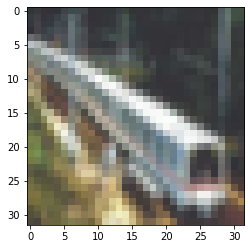

In [6]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

### Defining hyperparameters according to iCarl paper

In [7]:
# Settings
DEVICE = 'cuda'
NUM_CLASSES = 100         # Total number of classes
VAL_SIZE = 0.2            # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128          # Batch size
LR = 2                    # Initial learning rate
                       
MOMENTUM = 0.9            # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5       # Weight decay from iCaRL

RANDOM_SEED = [42,13,10]  # Random seeds defining the runs of every method
                          # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70           # Total number of training epochs
MILESTONES = [49, 63]     # Step down policy from iCaRL (MultiStepLR)
                          # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2               # Gamma factor from iCaRL (1/5)

## Fine Tuning

### Definition of `do_shuffle` and `do_group_classes`
`do_shuffle` and `do_group_classes` are two functions that rispectively shuffle data downloaded from Cifar100 and get the incremental classes division for the incremental learning phase.



In [8]:
def do_shuffle(train_d, test_d):
  train_d.__shuffle_seed__(RANDOM_SEED[run])
  test_d.__shuffle_seed__(RANDOM_SEED[run])
  return train_d, test_d

def do_group_classes(train_d, test_d):
  indexes_train_data = train_d.__incremental_indexes__(True)
  indexes_test_data = test_d.__incremental_indexes__(False)


  train_dataloader = [[] for i in range(10)]
  val_dataloader = [[] for i in range(10)]
  test_dataloader = [[] for i in range(10)]
  for i in range(10):
    train_dataset = Subset(train_d, indexes_train_data[i])
    train_set, val_set = torch.utils.data.random_split(train_dataset, 
                                                       [int((1-VAL_SIZE)*len(indexes_train_data[i])), int(VAL_SIZE*len(indexes_train_data[i]))])
    tmp_dl = DataLoader(train_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    train_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi 
    tmp_dl = DataLoader(val_set, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    val_dataloader[i] = copy(tmp_dl) # gruppi di 10 classi


    test_dataset = Subset(test_d, indexes_test_data[i])
    tmp_dl = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4,
                        drop_last=True)
    test_dataloader[i] = copy(tmp_dl) # classi incrementali: 0:0-9, 1:0-19, 2:0-29, ..., 9:0-99
    
  return train_dataloader, val_dataloader, test_dataloader

### Going on with the model
This is the main FineTuning step.

This step is run 3 times with different `RANDOM_SEED`.
Here the model is instantiated, trained and tested.

Results and some statistics are then stored in the variable `logs`.

In [9]:
logs = [{'preds': [], 
         'acc_test': [], 
         'true_lbls': [],
         'epochs_losses': []} for i in range(len(RANDOM_SEED))]

for run in range(len(RANDOM_SEED)):
  print("#################################")
  print(f"Radom seed: {RANDOM_SEED[run]}")
  print("")



  #shuffle data
  train_data, test_data = do_shuffle(train_data, test_data)
  #get dataloader separated in incremental groups of 10 classes
  train_dl, val_dl, test_dl = do_group_classes(train_data, test_data)

  #create the resnet
  net = resnet32()

  #define criterion, parameters, optimizer and scheduler
  criterion = nn.BCEWithLogitsLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)
  
  #create instance of the trainer.class
  #trainer = Trainer(
  #    device = DEVICE,
  #    net = net,
  #    criterion = criterion,
  #    optimizer = optimizer,
  #    scheduler = scheduler,
  #    train_dl = train_dl,
  #    validation_dl = val_dl,
  #    test_dl = test_dl
  #)
  trainer = Trainer(DEVICE,
                    net,
                    LR,
                    MOMENTUM,
                    WEIGHT_DECAY,
                    MILESTONES,
                    GAMMA,
                    train_dl,
                    val_dl,
                    test_dl)

  #try different num_epochs
  num_epochs = 80

  #train and evaluate the model
  logs[run]['epochs_losses'], logs[run]['acc_test'], logs[run]['true_lbls'], logs[run]['preds']  = trainer.train_model(num_epochs)



  print("#################################")
  print("")
  print("")

#################################
Radom seed: 42



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
Validation on group[8] of 10 classes
val loss: 0.010829970639731203
val acc: 0.8180803571428571

Epoch[19] loss: 0.0037815170137271764 LR: [2]
Validation on group[8] of 10 classes
val loss: 0.01359366053449256
val acc: 0.7979910714285714

Epoch[20] loss: 0.0036926943237983413 LR: [2]
Validation on group[8] of 10 classes
val loss: 0.011042883087481772
val acc: 0.8337053571428571
Best model updated

Epoch[21] loss: 0.0038460286882435603 LR: [2]
Validation on group[8] of 10 classes
val loss: 0.021599365398287773
val acc: 0.7332589285714286

Epoch[22] loss: 0.003564188223061783 LR: [2]
Validation on group[8] of 10 classes
val loss: 0.011894283017941884
val acc: 0.8270089285714286

Epoch[23] loss: 0.0033596038870934036 LR: [2]
Validation on group[8] of 10 classes
val loss: 0.0165113311793123
val acc: 0.7712053571428571

Epoch[24] loss: 0.002990162446944704 LR: [2]
Validation on group[8] of 10 classes
val loss: 0.010197899636945553
val acc: 

### Print some graphs

In [ ]:
### salvataggio modello da testare
torch.save(trainer.best_net.state_dict(), "./state")
model2 = resnet32()

in_features = model2.fc.in_features  # size of each input sample
out_features = model2.fc.out_features  # size of each output sample
weight = model2.fc.weight.data
model2.fc = nn.Linear(in_features, 100)
model2.fc.weight.data[:out_features] = weight


model2.load_state_dict(torch.load("./state"))

trainer2 = Trainer(DEVICE,
                    model2,
                    LR,
                    MOMENTUM,
                    WEIGHT_DECAY,
                    MILESTONES,
                    GAMMA,
                    train_dl,
                    val_dl,
                    test_dl)
trainer.best_net = model2
accuracy, all_targets, all_preds = trainer2.test(9)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plotConfusionMatrix(confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix - seed: {}".format(seed))

	#filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	#plt.savefig(filename, format='png', dpi=300)
	plt.show()
 
for i in range(len(RANDOM_SEED)):  
  t = logs[i]['acc_true_lblstest'].cpu().data.numpy()
  p = logs[i]['preds'].cpu().data.numpy()
  confusionMatrixData = confusion_matrix(t, p)
  plotConfusionMatrix(confusionMatrixData, RANDOM_SEED[i])